In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

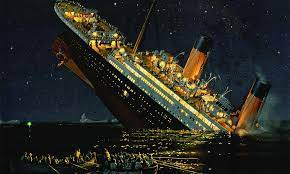

# Titanic - Machine Learning from Disaster


The objective of this notebook is to follow a step-by-step workflow, explaining each step and rationale for every decision we take during solution development.

## Workflow stages

The competition solution workflow goes through seven stages described in the Data Science Solutions book.

1. Question or problem definition.
2. Acquire training and testing data.
3. Wrangle, prepare, cleanse the data.
4. Analyze, identify patterns, and explore the data.
5. Model, predict and solve the problem.
6. Visualize, report, and present the problem solving steps and final solution.
7. Supply or submit the results.

The workflow indicates general sequence of how each stage may follow the other. However there are use cases with exceptions.

## Question and problem definition

Competition sites like Kaggle define the problem to solve or questions to ask while providing the datasets for training your data science model and testing the model results against a test dataset. The question or problem definition for Titanic Survival competition is [described here at Kaggle](https://www.kaggle.com/c/titanic).

> Knowing from a training set of samples listing passengers who survived or did not survive the Titanic disaster, can our model determine based on a given test dataset not containing the survival information, if these passengers in the test dataset survived or not.

We may also want to develop some early understanding about the domain of our problem. This is described on the [Kaggle competition description page here](https://www.kaggle.com/c/titanic). Here are the highlights to note.

- On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. Translated 32% survival rate.
- One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.
- Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

## Workflow goals

The data science solutions workflow solves for seven major goals.

**Classifying.** We may want to classify or categorize our samples. We may also want to understand the implications or correlation of different classes with our solution goal.

**Correlating.** One can approach the problem based on available features within the training dataset. Which features within the dataset contribute significantly to our solution goal? Statistically speaking is there a [correlation](https://en.wikiversity.org/wiki/Correlation) among a feature and solution goal? As the feature values change does the solution state change as well, and visa-versa? This can be tested both for numerical and categorical features in the given dataset. We may also want to determine correlation among features other than survival for subsequent goals and workflow stages. Correlating certain features may help in creating, completing, or correcting features.

**Converting.** For modeling stage, one needs to prepare the data. Depending on the choice of model algorithm one may require all features to be converted to numerical equivalent values. So for instance converting text categorical values to numeric values.

**Completing.** Data preparation may also require us to estimate any missing values within a feature. Model algorithms may work best when there are no missing values.

**Correcting.** We may also analyze the given training dataset for errors or possibly innacurate values within features and try to corrent these values or exclude the samples containing the errors. One way to do this is to detect any outliers among our samples or features. We may also completely discard a feature if it is not contribting to the analysis or may significantly skew the results.

**Creating.** Can we create new features based on an existing feature or a set of features, such that the new feature follows the correlation, conversion, completeness goals.

**Charting.** How to select the right visualization plots and charts depending on nature of the data and the solution goals.

In [ ]:
#data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling as pp

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

## Acquire data

The Python Pandas packages helps us work with our datasets. We start by acquiring the training and testing datasets into Pandas DataFrames. We also combine these datasets to run certain operations on both datasets together.

In [ ]:
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')
combine = [train_df, test_df]

## Analyze by describing data

Pandas also helps describe the datasets answering following questions early in our project.

**Which features are available in the dataset?**

Noting the feature names for directly manipulating or analyzing these. These feature names are described on the [Kaggle data page here](https://www.kaggle.com/c/titanic/data).

In [ ]:
print(train_df.columns.values)

**Which features are categorical?**

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

- Categorical: Survived, Sex, and Embarked. Ordinal: Pclass.

**Which features are numerical?**

Which features are numerical? These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

- Continous: Age, Fare. Discrete: SibSp, Parch.

In [ ]:
# preview the data
train_df.head()

**Which features are mixed data types?**

Numerical, alphanumeric data within same feature. These are candidates for correcting goal.

- Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric.

**Which features may contain errors or typos?**

This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.

- Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.

In [ ]:
train_df.tail()

**Which features contain blank, null or empty values?**

These will require correcting.

- Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.
- Cabin > Age are incomplete in case of test dataset.

**What are the data types for various features?**

Helping us during converting goal.

- Seven features are integer or floats. Six in case of test dataset.
- Five features are strings (object).

In [ ]:
train_df.info()
print('_'*40)
test_df.info()

**What is the distribution of numerical feature values across the samples?**

This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain.

- Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
- Survived is a categorical feature with 0 or 1 values.
- Around 38% samples survived representative of the actual survival rate at 32%.
- Most passengers (> 75%) did not travel with parents or children.
- Nearly 30% of the passengers had siblings and/or spouse aboard.
- Fares varied significantly with few passengers (<1%) paying as high as $512.
- Few elderly passengers (<1%) within age range 65-80.

In [ ]:
train_df.describe()
# Review survived rate using `percentiles=[.61, .62]` knowing our problem description mentions 38% survival rate.
# Review Parch distribution using `percentiles=[.75, .8]`
# SibSp distribution `[.68, .69]`
# Age and Fare `[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99]`

**What is the distribution of categorical features?**

- Names are unique across the dataset (count=unique=891)
- Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
- Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.
- Embarked takes three possible values. S port used by most passengers (top=S)
- Ticket feature has high ratio (22%) of duplicate values (unique=681).

In [ ]:
train_df.describe(include=['O'])

### Assumtions based on data analysis

We arrive at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions.

**Correlating.**

We want to know how well does each feature correlate with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

**Completing.**

1. We may want to complete Age feature as it is definitely correlated to survival.
2. We may want to complete the Embarked feature as it may also correlate with survival or another important feature.

**Correcting.**

1. Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
2. Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
3. PassengerId may be dropped from training dataset as it does not contribute to survival.
4. Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

**Creating.**

1. We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
2. We may want to engineer the Name feature to extract Title as a new feature.
3. We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
4. We may also want to create a Fare range feature if it helps our analysis.

**Classifying.**

We may also add to our assumptions based on the problem description noted earlier.

1. Women (Sex=female) were more likely to have survived.
2. Children (Age<?) were more likely to have survived. 
3. The upper-class passengers (Pclass=1) were more likely to have survived.

## Analyze by pivoting features

To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type.

In [ ]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [ ]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [ ]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [ ]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

## Analyze by visualizing data

Now we can continue confirming some of our assumptions using visualizations for analyzing the data.

### Correlating numerical features

Let us start by understanding correlations between numerical features and our solution goal (Survived).

A histogram chart is useful for analyzing continous numerical variables like Age where banding or ranges will help identify useful patterns. The histogram can indicate distribution of samples using automatically defined bins or equally ranged bands. This helps us answer questions relating to specific bands (Did infants have better survival rate?)

Note that x-axis in historgram visualizations represents the count of samples or passengers.

**Observations.**

- Infants (Age <=4) had high survival rate.
- Oldest passengers (Age = 80) survived.
- Large number of 15-25 year olds did not survive.
- Most passengers are in 15-35 age range.

**Decisions.**

This simple analysis confirms our assumptions as decisions for subsequent workflow stages.

- We should consider Age (our assumption classifying #2) in our model training.
- Complete the Age feature for null values (completing #1).
- We should band age groups (creating #3).

In [ ]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

### Correlating numerical and ordinal features

We can combine multiple features for identifying correlations using a single plot. This can be done with numerical and categorical features which have numeric values.

**Observations.**

- Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption #2.
- Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption #2.
- Most passengers in Pclass=1 survived. Confirms our classifying assumption #3.
- Pclass varies in terms of Age distribution of passengers.

**Decisions.**

- Consider Pclass for model training.

In [ ]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### Correlating categorical features

Now we can correlate categorical features with our solution goal.

**Observations.**

- Female passengers had much better survival rate than males. Confirms classifying (#1).
- Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
- Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. Completing (#2).
- Ports of embarkation have varying survival rates for Pclass=3 and among male passengers. Correlating (#1).

**Decisions.**

- Add Sex feature to model training.
- Complete and add Embarked feature to model training.

In [ ]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

### Correlating categorical and numerical features

We may also want to correlate categorical features (with non-numeric values) and numeric features. We can consider correlating Embarked (Categorical non-numeric), Sex (Categorical non-numeric), Fare (Numeric continuous), with Survived (Categorical numeric).

**Observations.**

- Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.
- Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).

**Decisions.**

- Consider banding Fare feature.

In [ ]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

# **Data overview**

In [ ]:
pp.ProfileReport(train_df)

Stay Tuned!!
